In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
Base.metadata.tables

FacadeDict({'measurement': Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x13f83c7fa70>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
date_max = session.query(func.max(measurement.date)).scalar()
date_max

'2017-08-23'

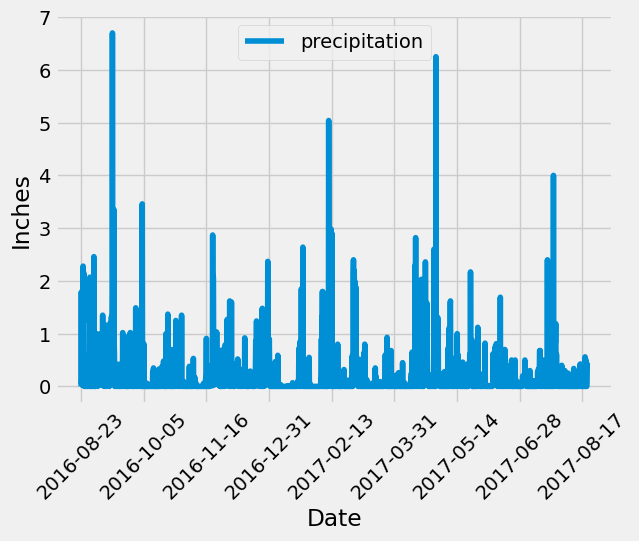

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year = dt.date(2017, 8, 23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data_year = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_df = pd.DataFrame(data_year, columns=["date", "precipitation"]).sort_values("date", ascending=True).dropna()
last_year_df.set_index('date', inplace= True)
last_year_df

# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot(xlabel="Date", ylabel="Inches", rot=45)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
disticnt_station = session.query(func.count(station.station)).all()
disticnt_station

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(station.station, func.count(measurement.station)).where(measurement.station == station.station).group_by(station.station).order_by(func.count(measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_ave = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).where(measurement.station == "USC00519281").all()
temp_ave

[(54.0, 85.0, 71.66378066378067)]

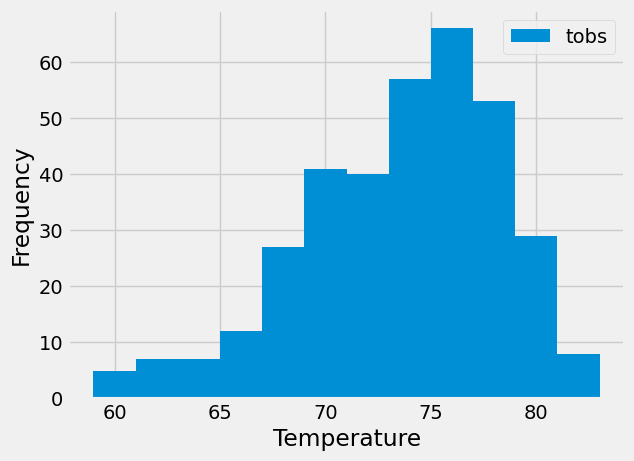

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(measurement.tobs).where(measurement.station == "USC00519281").where(measurement.date >= last_year).all()
temp_df = pd.DataFrame(temps, columns= ["tobs"])
temp_df.plot.hist(xlabel="Temperature", bins= 12)
plt.show()

# Close Session

In [18]:
# Close Session
session.close()